In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import os

import pandas as pd
import seaborn as sns
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
from h2o.automl import H2OAutoML

cc_fraud = pd.read_csv("creditcard.csv")

## Exploratory Data Analysis
We can see thag Amount is fairly scewed to the left with the mean being 4 times the median, also there are 1825 (less than 1%) transactions that have a zero Amount. The dataset does not have any missing values. As expect since variables V1 to V28 come out of a PCA they are completely uncorrelated. V7 and V2 have the highest positive and negative correlation with Amount, and V5 and V3 - with Time.


In [2]:
cc_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
cc_fraud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
cc_fraud.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
# number of zero Amounts
cc_fraud.Amount.loc[cc_fraud.Amount==0].count()

1825

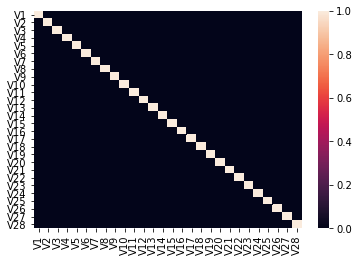

In [6]:
# heatmap only for variables V1 to V28
corr_v = cc_fraud.drop(['Time', 'Amount', 'Class'], axis=1).corr()
sns.heatmap(corr_v, xticklabels=corr_v.columns.values, yticklabels=corr_v.columns.values)

In [7]:
# correlations between Time and Amount and the PCA-variables
corr_sub = cc_fraud.drop(['Class'], axis=1).corr()
corr_sub = corr_sub.loc[~corr_sub.index.isin(['Time', 'Amount']), ['Amount', 'Time']]
corr_sub

,Amount,Time
V1,-0.227709,0.117396
V2,-0.531409,-0.010593
V3,-0.210880,-0.419618
V4,0.098732,-0.105260
V5,-0.386356,0.173072
V6,0.215981,-0.063016
V7,0.397311,0.084714
V8,-0.103079,-0.036949
V9,-0.044246,-0.008660
V10,-0.101502,0.030617


In [8]:
corr_sub.loc[(corr_sub.Amount == corr_sub.Amount.max()) | (corr_sub.Amount == corr_sub.Amount.min()), ['Amount']]

,Amount
V2,-0.531409
V7,0.397311


In [9]:
corr_sub.loc[(corr_sub.Time == corr_sub.Time.max()) | (corr_sub.Time == corr_sub.Time.min()), ['Time']]

,Time
V3,-0.419618
V5,0.173072


## Fraud Detection Patterns
Non fraudulent transaction have a significantly different average value compared to the fraudulent ones, however fraudulent transactions' amounts vary more (their amounts have higher interquartile range). Non fraudulent transactions follow more smooth distribution across Time, whereas fraudulent transactions have random looking spikes throughout the whole time spectrum. Variables 'V3', 'V7', 'V10', 'V12', 'V14' and 'V17' have quite different distributions between the fraudulent and the non fraudulent transactions, where the non fraudulent transactions have a more flat distribution and a lower center.

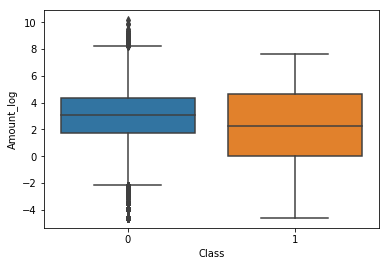

In [10]:
# log transform Amount and box-plot
# In order to make the patterns in the data more interpretable Amount has been log transformed
cc_fraud['Amount_log'] = np.log(cc_fraud.Amount + 0.01)
sns.boxplot(x="Class", y="Amount_log", data=cc_fraud)
plt.show()

In [11]:
cc_fraud.groupby('Class').Amount_log.std()

Class
0    1.948358
1    2.967482
Name: Amount_log, dtype: float64

In [12]:
# we can reject the null hypothesis that fraudulent and non fraudulent amounts have equal variances
stats.levene(cc_fraud.loc[cc_fraud.Class == 0, 'Amount'], cc_fraud.loc[cc_fraud.Class == 1, 'Amount'])

LeveneResult(statistic=12.684214894874506, pvalue=0.0003688154902664781)

In [13]:
# we are dealing with fairly big sample sizes so a Welch’s t-test with non qual variances should give a non biased result
# the average amount is different across classes
stats.ttest_ind(cc_fraud.loc[cc_fraud.Class == 0, 'Amount'], cc_fraud.loc[cc_fraud.Class == 1, 'Amount'], equal_var=False)

Ttest_indResult(statistic=-2.928789530856467, pvalue=0.003560518851710299)

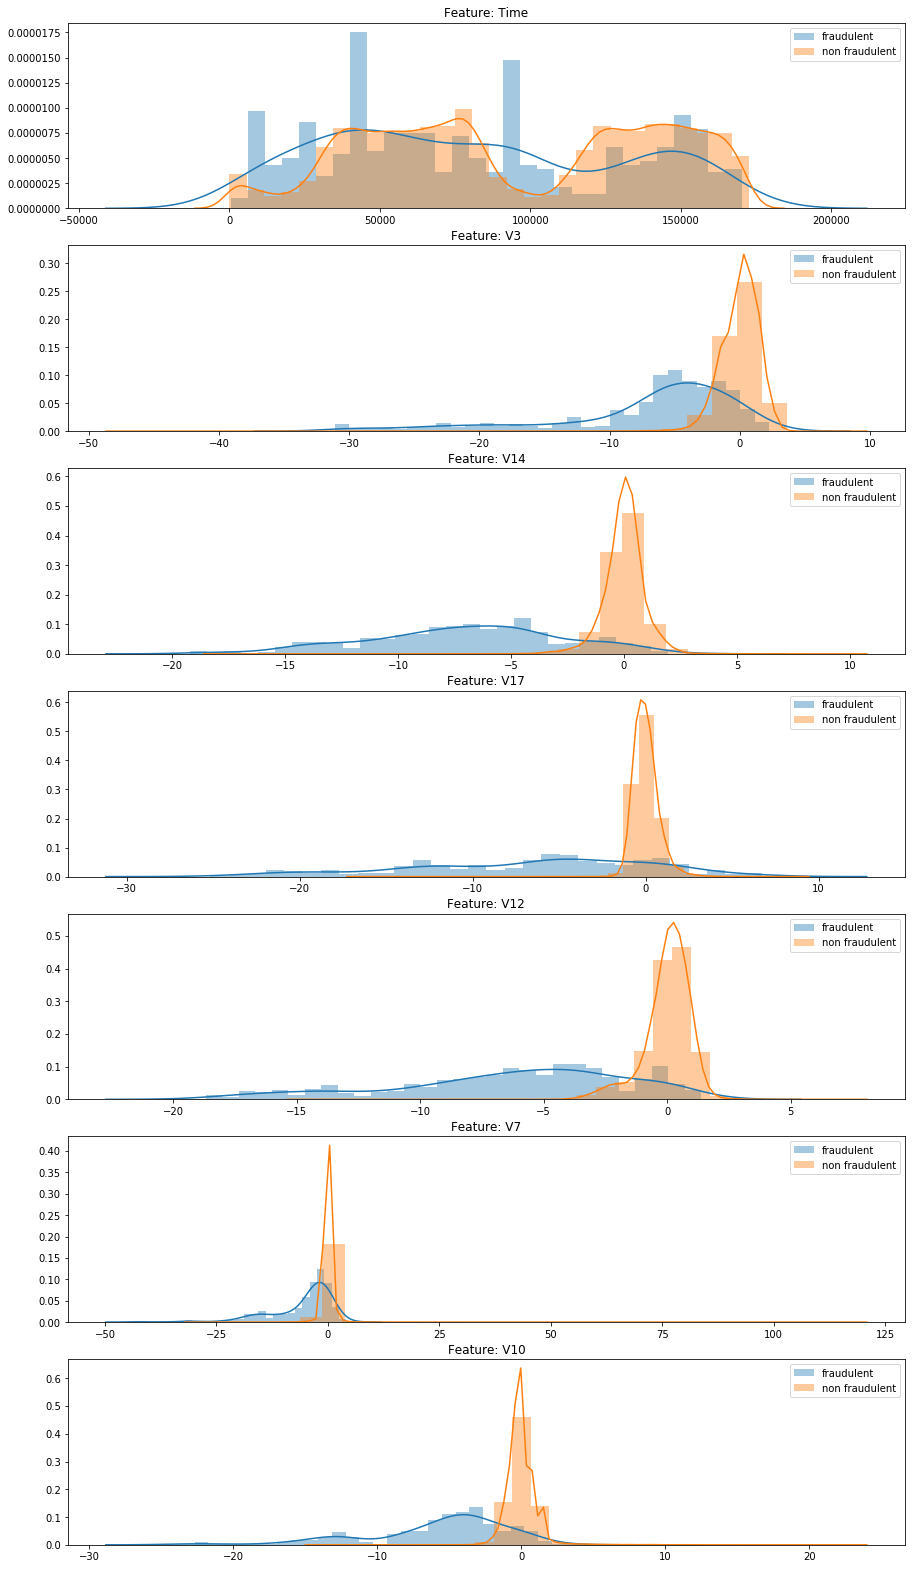

In [14]:
# plot the distributions of the top few variables and Time by class
# look only at the variables that have the highest absolute difference in either mean, median or standard deviation between the
# non fraudulent and the fraudulent class
eda = cc_fraud.drop(['Amount', 'Amount_log', 'Time'], axis=1)\
    .groupby('Class')\
    .aggregate(['mean', 'median', 'std'])\
    .diff()\
    .T\
    .reset_index()
eda['abs_diff'] = eda[eda.columns[3]].abs()
eda_sub = eda.sort_values('abs_diff', ascending=False).head(10)
features = np.append( 'Time', eda_sub.level_0.unique())
nplots = np.size(features)
plt.figure(figsize=(15, 4*nplots))
gs = gridspec.GridSpec(nplots, 1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(cc_fraud[feat][cc_fraud.Class == 1], bins=30)
    sns.distplot(cc_fraud[feat][cc_fraud.Class == 0], bins=30)
    ax.legend(['fraudulent', 'non fraudulent'], loc='best')
    ax.set_xlabel('')
    ax.set_title('Feature: ' + feat)

## Predicting Fraudulent Transactions
Four different approaches have been tested. A logistic regression, a random forest, a gradient boosting and a feedforward neural network. Since we are dealing with highly unbalanced data we will use the precision recall area under curve (PR AUC) for an accuracy metric - basically ignore true postive rate and calculate area under precision over recall. The best model is a GBM and has a PR AUC of 0.843.

### Logistic Regression
Given the big unbalance observed in the data a logistic regression does fairly well in identifying fraudulent transaction with sensitivity score of 81.4% on the test dataset and PR AUC of 0.588. This means that there are patterns in the data that can help us distinguish between fraudulent and non fraudulent transactions. Including interactions between the most highly correlated independent variables does not improve PR AUC. Variables V10, V4 and V27 are the strongest predictors of fraudulent transactions. Further analysis of the loadings can bring more interpretability to the results.

### Random Forest
A Random Forest performs better than the Logistic Regression with PR AUC of 0.794. A random forest ran on adjusted for the skewed distribution datasets performs slightly better than the initial one with PR AUC of 0.806. A grid search on both the tree specific as well as the boosting parameters could improve the performance.

### Gradient Boosting
A GBM ran on a balanced sample has a test PR AUC of 0.597. After a grid search the GBM achieves a PR AUC of 0.843.

### Feedforward Neural Network
Using some sensible prespecified parameters and training for 200 epochs the NN gets test PR AUC of 0.442. Including dropout for the hidden layers and training for longer might improve test performance.


In [15]:
# start up a local 1-node H2O cloud
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.1+13-LTS, mixed mode)
  Starting server from c:\python27\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: c:\users\pedro\appdata\local\temp\tmp4mg5kb
  JVM stdout: c:\users\pedro\appdata\local\temp\tmp4mg5kb\h2o_pedro_started_from_python.out
  JVM stderr: c:\users\pedro\appdata\local\temp\tmp4mg5kb\h2o_pedro_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,1 month and 9 days
H2O cluster name:,H2O_from_python_pedro_lagqj5
H2O cluster total nodes:,1
H2O cluster free memory:,1.969 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [16]:
# from pandas to h2o
cc_fraud_h2o = h2o.H2OFrame(cc_fraud.drop('Amount_log', axis=1))

c:\python27\lib\site-packages\h2o\utils\shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [17]:
# split to train, validation and test
cc_fraud_h2o["Class"] = cc_fraud_h2o["Class"].asfactor()
train, valid, test = cc_fraud_h2o.split_frame([0.7, 0.15], seed=1234)
IV = cc_fraud_h2o.col_names[:-1]
DV = cc_fraud_h2o.col_names[-1]

In [18]:
# Logistic regression
# Time and Amount are on different scales compared to the PCA variables set standardize=True will handle that, So cool!
# 28 out of the 30 IV come from a PCA, we dont need to worry about multicollinearity. We can set lambda to be equal to 0 and 
# estimate p_values
glm_binom = H2OGeneralizedLinearEstimator(
    model_id="glm",
    solver="IRLSM",
    family="binomial",
    standardize=True, 
    lambda_=0,
    compute_p_values=True,
    seed=1234
)

glm_binom.train(IV, DV, training_frame=train, validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [19]:
glm_binom.model_performance(test).pr_auc()

0.588153731024078

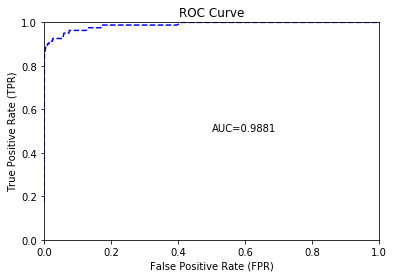

In [20]:
# the ROC AUC is indeed very high it will be difficult to distinguish between models using only it
glm_binom.model_performance(test).plot()

In [21]:
glm_binom.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0887006259255: 


,0,1,Error,Rate
0,42530.0,20.0,0.0005,(20.0/42550.0)
1,15.0,66.0,0.1852,(15.0/81.0)
Total,42545.0,86.0,0.0008,(35.0/42631.0)


In [22]:
coef_table = glm_binom._model_json['output']['coefficients_table'].as_data_frame()
coef_table['coefficients_abs'] = abs(coef_table['coefficients'])
coef_table.sort_values('coefficients_abs', ascending = False).head()

,names,coefficients,std_error,z_value,p_value,standardized_coefficients,coefficients_abs
0,Intercept,-8.512284,0.313131,-27.184445,0.000000e+00,-8.743330,8.512284
11,V10,-0.822632,0.129839,-6.335774,2.361521e-10,-0.893811,0.822632
5,V4,0.771577,0.105685,7.300725,2.862155e-13,1.090437,0.771577
28,V27,-0.735751,0.156113,-4.712931,2.441794e-06,-0.297165,0.735751
23,V22,0.533115,0.168048,3.172400,1.511848e-03,0.386744,0.533115


In [23]:
# Logistic regression with interactions, include only the interactions between the PCA variables and Time and Amount that have
# the highest correlation
# can test further if including mode interactions will improve performance
glm_binom_int = H2OGeneralizedLinearEstimator(
    model_id="glm_int",
    solver="IRLSM",
    family="binomial",
    standardize=True, 
    lambda_=0,
    compute_p_values=True,
    interaction_pairs=[('Time', 'V3'), ('Time', "V5"), ('Amount', 'V2'), ('Amount', 'V7')],
    seed=1234
)

glm_binom_int.train(IV, DV, training_frame=train, validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [24]:
glm_binom_int.model_performance(test).pr_auc()

0.5537443780124984

In [25]:
# Random forest
# min_rows specifies the minimum number of observations for a leaf, its better to be set to a low number since we have an 
# unbalanced sample
rf_mod = H2ORandomForestEstimator(
    model_id="rf",
    binomial_double_trees=False,
    ntrees=200,
    max_depth=8,
    min_rows=25,
    stopping_rounds=2,
    stopping_tolerance=0.001,
    # nfolds=5, # evaluate based on cross validation
    # fold_assignment='stratified' # stratified cross validation
    seed=1234
)
# rf_mod.train(IV, DV, training_frame=train) # when we evaluate based on CV test data AUC is 97.44. It is slower but better
# when we dont have enough data
rf_mod.train(IV, DV, training_frame=train, validation_frame=valid) # evaluate based on the validation data, better test AUC

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [26]:
rf_mod.model_performance(test).pr_auc()

0.7942660555248207

In [27]:
# Random forest with data weighting
# In the data less than 1% of the transactions are fraudulent. If we set balance_class=True the default behaviour is to
# oversample the underrepresented class till a balanced sample is achieved, which means that fraudulent rows will have a weight
# of more than 500. Tested a few less extreme sample weights, both oversampling fraudulent transactions and undersampling
# non fraudulent, and best PR AUC is achieved when giving fraudulent transactions a weight of 5 and non fraudulent a weight 
# of 0.5. Maybe it is worth running a grid search
rf_mod_bal = H2ORandomForestEstimator(
    model_id="rf_bal",
    binomial_double_trees=False,
    ntrees=200,
    max_depth=8,
    min_rows=25,
    stopping_rounds=2,
    stopping_tolerance=0.001,
    balance_classes=True,
    class_sampling_factors=[0.5, 5.0], 
    seed=1234
)
rf_mod_bal.train(IV, DV, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [28]:
rf_mod_bal.model_performance(test).pr_auc()

0.8057144889090778

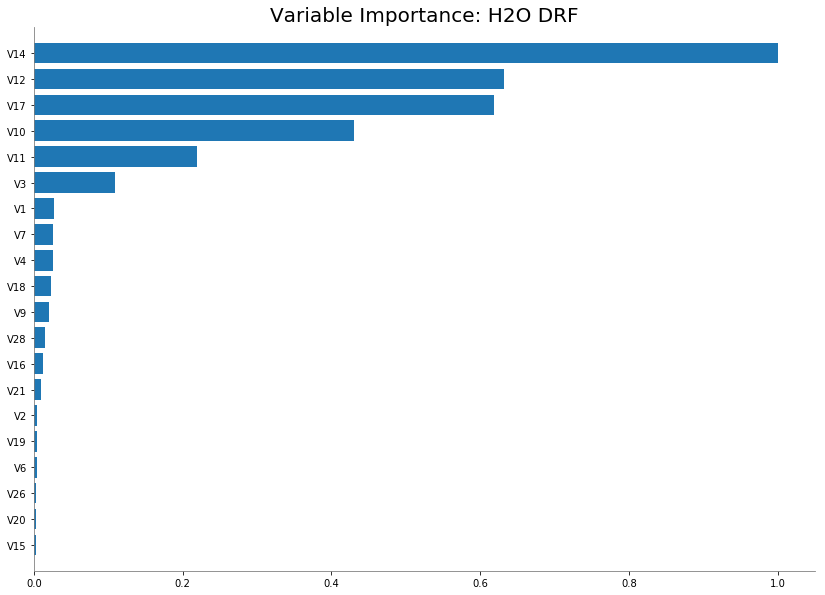

In [29]:
# look at variable importance based on gini
rf_mod_bal.varimp_plot(20)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


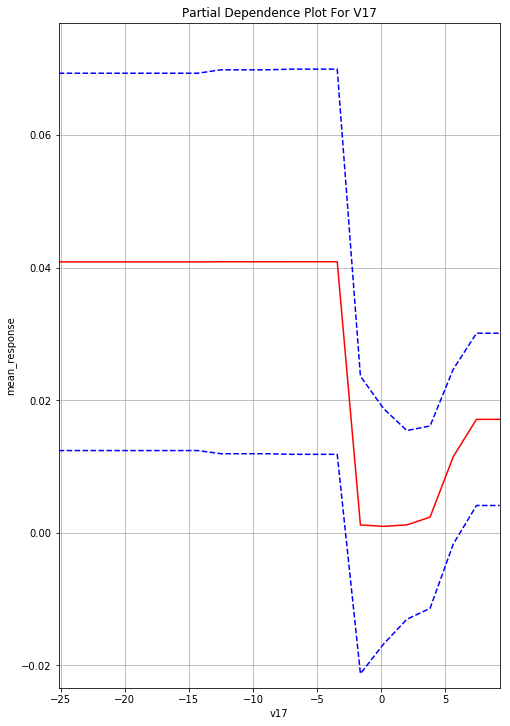

In [30]:
# partial dependency plot shows us that as V17 increases from -5 to -1, the likelihood of fraudelent transaction decreases
pdp = rf_mod_bal.partial_plot(cols=["V17"], data=train) 

c:\python27\lib\site-packages\matplotlib\__init__.py:1867: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


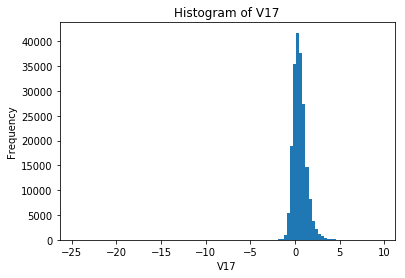

In [31]:
train['V17'].hist(breaks=100)

In [32]:
# Gradient Boosting
gbm = H2OGradientBoostingEstimator(
    model_id="gbm",
    ntrees=200,
    max_depth=8,
    min_rows=25,
    learn_rate=0.01,
    stopping_tolerance=0.001, 
    stopping_rounds=2, # early stopping
    balance_classes=True,
    seed=1234
)
gbm.train(IV, DV, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [33]:
gbm.model_performance(test).pr_auc()

0.5968563601001523

In [34]:
# Grid search GBM
gbm_params = {'learn_rate': 0.01,
              'max_depth': [5, 8],
              'min_rows': [15, 25, 35],
              'ntrees': 200,
              'stopping_tolerance': 0.001,
              'stopping_rounds': 2,
              'balance_classes': [True, False],
              'class_sampling_factors': [[0.5, 1.0], [0.5, 5.0], [1.0, 10.0]],
              'seed': 1234}
grid_search = H2OGridSearch(H2OGradientBoostingEstimator, hyper_params=gbm_params)
grid_search.train(IV, DV, training_frame=train, validation_frame=valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [35]:
# look at the parameters for the best model
best_prauc = 0
for id_model, model in enumerate(grid_search.models):
    prauc = model.model_performance(test).pr_auc()
    conf_m = model.model_performance(test).confusion_matrix()
    if prauc > best_prauc:
        best_prauc = prauc
        best_conf_m = conf_m
        best_auc_id = id_model
best_model = grid_search[best_auc_id]

list_model_params = list(best_model.params.keys())
bmps = best_model.params.items()

max_depth = bmps[list_model_params.index('max_depth')][1]['actual']
min_rows = bmps[list_model_params.index('min_rows')] [1]['actual']
sample_rate = bmps[list_model_params.index('sample_rate')] [1]['actual']
balance_classes = bmps[list_model_params.index('balance_classes')][1]['actual']
class_sampling_factors = bmps[list_model_params.index('class_sampling_factors')][1]['actual']

In [36]:
print ('''Best model PR AUC: {}, with parameters max_depth: {}, min_rows: {}, sample_rate: {}, balance_classes: {}, 
       class_sampling_factors: {}'''
       .format(best_prauc, max_depth, min_rows, sample_rate, balance_classes, class_sampling_factors))

Best model PR AUC: 0.843356529063, with parameters max_depth: 8, min_rows: 35.0, sample_rate: 1.0, balance_classes: False, 
       class_sampling_factors: [0.5, 1.0]


In [37]:
conf_m

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.197221925616: 


,0,1,Error,Rate
0,42543.0,7.0,0.0002,(7.0/42550.0)
1,18.0,63.0,0.2222,(18.0/81.0)
Total,42561.0,70.0,0.0006,(25.0/42631.0)


In [39]:
# Forward Neural Net (slow on local)
dl =  H2ODeepLearningEstimator(
    model_id='dl',
    activation="rectifierwithdropout",
    input_dropout_ratio=0.3,
    hidden=[256, 256, 256],
    stopping_rounds=2,
    stopping_metric="logloss",
    epochs=200,
    seed=1234)
dl.train(IV, DV, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [42]:
dl.model_performance(test).pr_auc()

0.4418577297477588

## Explore AutoML
Without tweaking any parameters AutoML's best model has PR AUC on the test data of 0.587 which is slightly lower than the manually specified Logistic Regression model. The top model is a GLM.

In [43]:
# show me what you can do for 5 mins
aml = H2OAutoML(
    max_runtime_secs=300, 
    exclude_algos=["DeepLearning"],
    seed = 1234)
aml.train(IV, DV, training_frame=train, validation_frame=valid)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [44]:
aml.leaderboard[['model_id', 'logloss']] # GLM is the top model

model_id,logloss
GLM_grid_1_AutoML_20181206_092141_model_1,0.00398777
XRT_1_AutoML_20181206_092141,0.004133
DRF_1_AutoML_20181206_092141,0.00463025
StackedEnsemble_BestOfFamily_AutoML_20181206_092141,0.00301618
StackedEnsemble_AllModels_AutoML_20181206_092141,0.00301618
GBM_1_AutoML_20181206_092141,0.0195234


In [45]:
# get test AUC for the top model
top_model = aml.leaderboard['model_id'][0, 0]
h2o.get_model(top_model).model_performance(test).pr_auc()

0.5867324311564621

In [46]:
h2o.get_model(top_model).model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0773071127669: 


,0,1,Error,Rate
0,42529.0,21.0,0.0005,(21.0/42550.0)
1,15.0,66.0,0.1852,(15.0/81.0)
Total,42544.0,87.0,0.0008,(36.0/42631.0)
